<a href="https://colab.research.google.com/github/ibenoam/Neural_cryptography/blob/main/Neural_Cryptography_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-Cryptography:
### Solving the key exchange problem by synchronize Tree Parity Machines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pdb

Lets define our Tree-Parity Machine (TPM) class:

In [2]:
class TPM:
    def __init__(self,N,K,L,M=1):
        # Constants:
        self.N = N
        self.K = K
        self.L = L
        self.M = M

        # Initialization:
        self.w = np.floor((2*L+1) * np.random.rand(N,K)) - L
        self.init_w = copy.deepcopy(self.w)
        self.fields = np.zeros((1,K))
        self.sigmas = np.zeros((1,K))
        self.tau = 0
        self.init_entropy = self.entropy_calc()

    # The feed-forward process:
    def forward(self,input):
        self.fields = np.sum(self.w*input, axis=0)
        self.sigmas = np.sign(self.fields + 1e-10)
        self.tau = np.prod(self.sigmas)
  
    # updating the weights:
    def update(self,input):
        update_indexes = np.where(self.sigmas == self.tau)
        self.w[:,update_indexes] += input[:,update_indexes]
        self.w[np.abs(self.w)>self.L] = np.sign(self.w[np.abs(self.w)>self.L])*self.L

    # This function gets two sets of weights (flatten each of them to a vector), and calculates the correlation between them (or the cosinus between them).
    def correlation(self, other):
        w1 = np.transpose(self.w.flatten())
        w2 = other.w.flatten()
        corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
        return corr_val

    # This function gets two sets of weights (flatten each of them to a vector), and calculates the correlation between them (or the cosinus between them).
    def self_correlation(self):
        w1 = np.transpose(self.w.flatten())
        w2 = self.init_w.flatten()
        corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
        return corr_val

    def entropy_calc(self):
        entropy = 0
        unique, counts = np.unique(self.w, return_counts=True)
        probabilities = dict(zip(unique, counts/(self.N*self.K)))
        for _,prob in probabilities.items():
            if prob:
                entropy += -prob*np.log(prob) 
        return entropy 

Now, we define a few constants and initialize a list of dictionaries.
<br> Each dictionary has the following keys:
*   'sync_time': number of steps until Alice and Bob succeed to converge.
*   'attacker_time': number of steps until Eve is needed to converge.
*   'corr_alice'/('corr_bob'): the correlation between Alice's/(Bob's) final weights and the initial weights.
*   'corr_alice_bob': the correlation over time between Alice and Bob weights.
*   'corr_alice_eve': the correlation over time between Alice and Eve weights.


In [3]:
N = 10 # each N input neurons goes to 1 hidden neuron
L = 3 # the "synaptic" depth
K = 3 # number of perceptrons (or hidden layer size)
M = 1 # the input consists of integers in the range [-M,M] without 0

num_sys = 100 # we average each result "num_sys" times

data = {'sync_time': [], 'attacker_time': [], 'corr_alice': [], 'corr_bob': [], 'corr_alice_bob':  [[] for _ in range(num_sys)], 'corr_alice_eve':  [[] for _ in range(num_sys)], 'when_move': [[] for _ in range(num_sys)],'final_entropy':[]}

In [ ]:
for i in range(num_sys):
    # Generate Alice's and Bob's TPMs:
    alice = TPM(N,K,L)
    bob = TPM(N,K,L)
    # Generates the attacker's TPM:
    eve = TPM(N,K,L)

    count_steps = 0
    flag = True
    # while not np.array_equal(alice.w,bob.w):
    while not np.array_equal(alice.w,eve.w):

        # print(f"After {count_steps} steps.")
        count_steps += 1
        if flag:
            data['corr_alice_bob'][i].append(alice.correlation(bob))
            data['corr_alice_eve'][i].append(alice.correlation(eve))

            if np.array_equal(alice.w,bob.w): # and flag
                data['sync_time'].append(count_steps)
                data['corr_alice'].append(alice.self_correlation())
                data['corr_bob'].append(bob.self_correlation())
                data['final_entropy'].append(alice.entropy_calc())
                flag = False

        # inputs = np.sign(np.random.rand(N,K)-0.5)
        inputs = (np.random.randint(M,size=(N,K))+1)*(np.sign(np.random.rand(N,K)-0.5))
        alice.forward(inputs)
        bob.forward(inputs)
  
        # According to the algorithm, Alice and Bob take a step only when their outputs are identical:
        if alice.tau == bob.tau:
            data['when_move'][i].append(1)
            alice.update(inputs)
            bob.update(inputs)
        else:
            data['when_move'][i].append(0)
      
        ''' The best strategy for an attacker with only 1 TPM:
        When Eve gets the same output like Alice- she updates the weights according to the same learning rule.
        But, because of the fact that she cannot influence the dynamics between Alice and Bob, she has to do something
        even when her output is different, otherwise she does not have a real chance.
        So, she looks for the perceptron with the minimal absolute field (has the less "confidence") and flips it.
        Then, her output becomes identical to Alice's output and she can updates according to the regular learning rule.
        '''
        eve.forward(inputs)
        if eve.tau == alice.tau:
            eve.update(inputs)
        else:
            min_field_index = np.argmin(np.abs(eve.fields))
            eve.sigmas[min_field_index] *= -1 # flips a field
            eve.tau *= -1 # which flips the output
            eve.update(inputs)
        # data['corr_alice_eve'][i].append(alice.correlation(eve))

    print(f" finished {100*(i+1)/num_sys}% of the runtime")
    data['attacker_time'].append(count_steps)

In [ ]:
print(f" The average synchronization time between Alice and bob is {np.mean(data['sync_time']):.3f} steps with std of {np.std(data['sync_time']):.3f}")
print(f" The average learning time between of Eve is {np.mean(data['attacker_time']):.3f} steps with std of {np.std(data['attacker_time']):.3f}")

 The average synchronization time between Alice and bob is 216.140 steps with std of 68.471
 The average learning time between of Eve is 649.370 steps with std of 410.145


# Graphs

## Fig. 1: histogram of the synchronization time between Alice and bob

[]

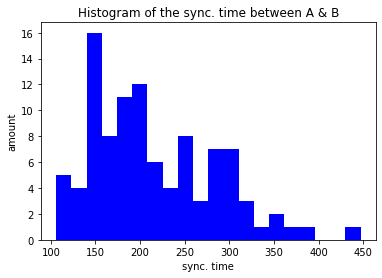

In [ ]:
plt.figure()
plt.hist(data['sync_time'], color = "blue", bins = 20)
plt.title('Histogram of the sync. time between A & B')
plt.xlabel("sync. time")
plt.ylabel("amount")
plt.plot()

We want to see that Eve didn't succeed to converge faster than Alice and Bob:

## Fig. 2: histogram of Eve's learning time

[]

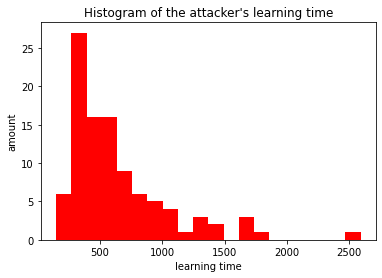

In [ ]:
plt.hist(data['attacker_time'], color = "red",  bins = 20)
plt.title("Histogram of the attacker's learning time")
plt.xlabel("learning time")
plt.ylabel("amount")
plt.plot(c = 'red')

As we can see, in average Eve's learning time is greater than the synchronization time between Alice and Bob. **But** we want to know if there is a chance that Eve's time is better! so...

## Fig. 3: The ratio between Eve's learning time and the synchronization time

 The average ratio between the attacker learning time and the synchronization time is 3.211 with std of 2.243
 The minimal ratio  is 1.034


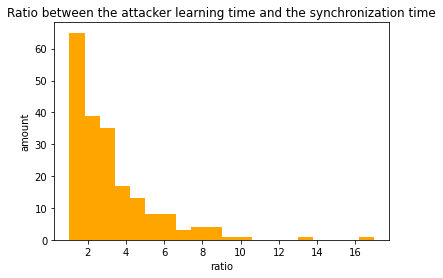

In [8]:
ratio_attack_sync = [i/j for i, j in zip(data['attacker_time'], data['sync_time'])]
data['ratio_attack_sync'] = ratio_attack_sync

plt.figure()
plt.hist(ratio_attack_sync, color = "orange", bins = 20)
plt.title('Ratio between the attacker learning time and the synchronization time')
plt.xlabel("ratio")
plt.ylabel("amount")
plt.plot()

print(f" The average ratio between the attacker learning time and the synchronization time is {np.mean(ratio_attack_sync):.3f} with std of {np.std(ratio_attack_sync):.3f}")
print(f" The minimal ratio  is {np.min(ratio_attack_sync):.3f}")

## Fig. 4: Histogram of the correlation between Alice's initial weights and her final weights

One can say that maybe if we know the initial state of Alice's weights we can evaluate where she will end.
<br> Therefore, we calculate the correlation between Alice's initial and her final weights:

 The average correlation between Alice's initial and final weights is -0.007 steps with std of 0.163


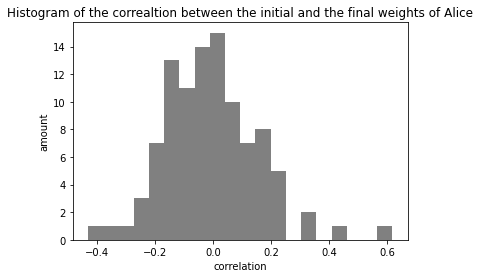

In [ ]:
plt.figure()
plt.hist(data['corr_alice'], color = "grey", bins = 20)
plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average correlation between Alice's initial and final weights is {np.mean(data['corr_alice']):.3f} steps with std of {np.std(data['corr_alice']):.3f}")

## Fig. 5: The weights correlation over time

The following graph shows that correlation between alice and bob increases faster than the correlation between alice and eve over learning steps:

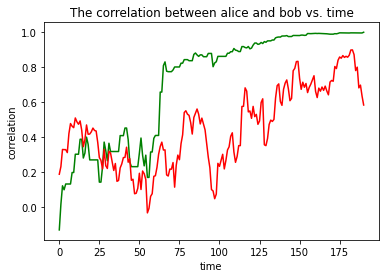

In [ ]:
plt.figure()
plt.title('The correlation between alice and bob vs. time')
plt.xlabel("time")
plt.ylabel("correlation")
plt.plot(range(len(data['corr_alice_bob'][0])), data['corr_alice_bob'][0], c = 'green')

plt.plot(range(len(data['corr_alice_eve'][0])), data['corr_alice_eve'][0], c = 'red')

plt.show()


## Fig. 6: The probability to get the same output over time

The following graphs confirm the assumption that as the correlation between Alice's and Bob's weights higher, the probability to get the same output is higher.

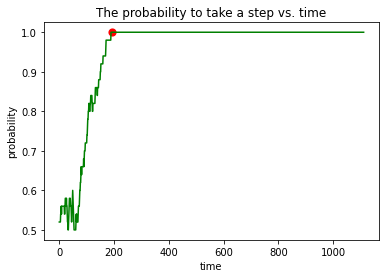

In [ ]:
# sliding window
window_size = 50
chance = []
for i in range(len(data['when_move'][0])-window_size+1):
    chance.append(sum(data['when_move'][0][i:i + window_size])/window_size)

plt.figure()
plt.title('The probability to take a step vs. time')
plt.xlabel("time")
plt.ylabel("probability")
plt.plot(range(len(chance)), chance, c = 'green')
plt.scatter(int(data['sync_time'][0]), chance[int(data['sync_time'][0])], c = 'red', s = 10, linewidth = 5)

### Graphs we want to show:
1. Histogram of the synchronization time between Alice and bob. --- done!
2. The chance of A&B to take a step (sliding window) --- done! 
3. The correlation between A&B over the learning time (vs. the attacker's correlation) - done!
4.  To show that the final weights are not correlated to the initial weights. - done!
5. Show how the sync time depends on the constants (N, L, K)- "errorbar"
6. examine how inputs in [-M, M] affects the information we can get from the final weights - final entropy.